# Modelling

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [38]:
hotels = pd.read_csv('hotels.csv')
searches = pd.read_csv('searches.csv')
td = pd.read_csv('train.csv')

In [39]:
clicked_hotels = td[["prop_id", "site_id", "prop_country_id", "click_bool", "booking_bool"]]
clicked_hotels["click_count"] = clicked_hotels["prop_id"].map(clicked_hotels["prop_id"].value_counts())
clicked_hotels.drop("click_bool", axis=1, inplace=True)
clicked_hotels_deneme = clicked_hotels.groupby("prop_country_id")["click_count"].sum()
click_book = clicked_hotels.groupby("prop_id")["booking_bool"].sum()
click_book = pd.DataFrame(click_book).reset_index().rename(columns={"booking_bool" : "sum_booking"})
clicked_hotels_deneme = pd.DataFrame(clicked_hotels_deneme).reset_index()
clicked_hotels = pd.merge(click_book, clicked_hotels, on="prop_id")
clicked_hotels = pd.merge(clicked_hotels_deneme, clicked_hotels, on="prop_country_id")
clicked_hotels["click_interaction"] = clicked_hotels["click_count_y"] / clicked_hotels["click_count_x"] * 10
clicked_hotels.drop(['click_count_x', 'click_count_y', 'site_id', "prop_country_id", "booking_bool"], axis=1, inplace=True)
clicked_hotels

/var/folders/0m/_y7l8ln90mlbfr427hwkgw000000gn/T/ipykernel_70802/3374621306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicked_hotels["click_count"] = clicked_hotels["prop_id"].map(clicked_hotels["prop_id"].value_counts())
/var/folders/0m/_y7l8ln90mlbfr427hwkgw000000gn/T/ipykernel_70802/3374621306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicked_hotels.drop("click_bool", axis=1, inplace=True)


,prop_id,sum_booking,click_interaction
0,23513,0,0.121107
1,23513,0,0.121107
2,23513,0,0.121107
3,23513,0,0.121107
4,23513,0,0.121107
...,...,...,...
4958342,140791,0,0.000330
4958343,140791,0,0.000330
4958344,140791,0,0.000330
4958345,140791,0,0.000330


In [40]:
clicked_hotels["sum_booking"].value_counts()

sum_booking
0     1266262
1      778862
2      559403
3      393975
4      306434
       ...   
59        820
90        815
68        612
54        371
85        314
Name: count, Length: 88, dtype: int64

In [41]:
clicked_hotels["search_percentage"] = clicked_hotels["prop_id"].map(td["prop_id"].value_counts()) / len(clicked_hotels["prop_id"].unique()) * 10
clicked_hotels["sum_booking"] = clicked_hotels["sum_booking"] / 100

In [42]:
clicked_hotels = clicked_hotels.drop_duplicates()

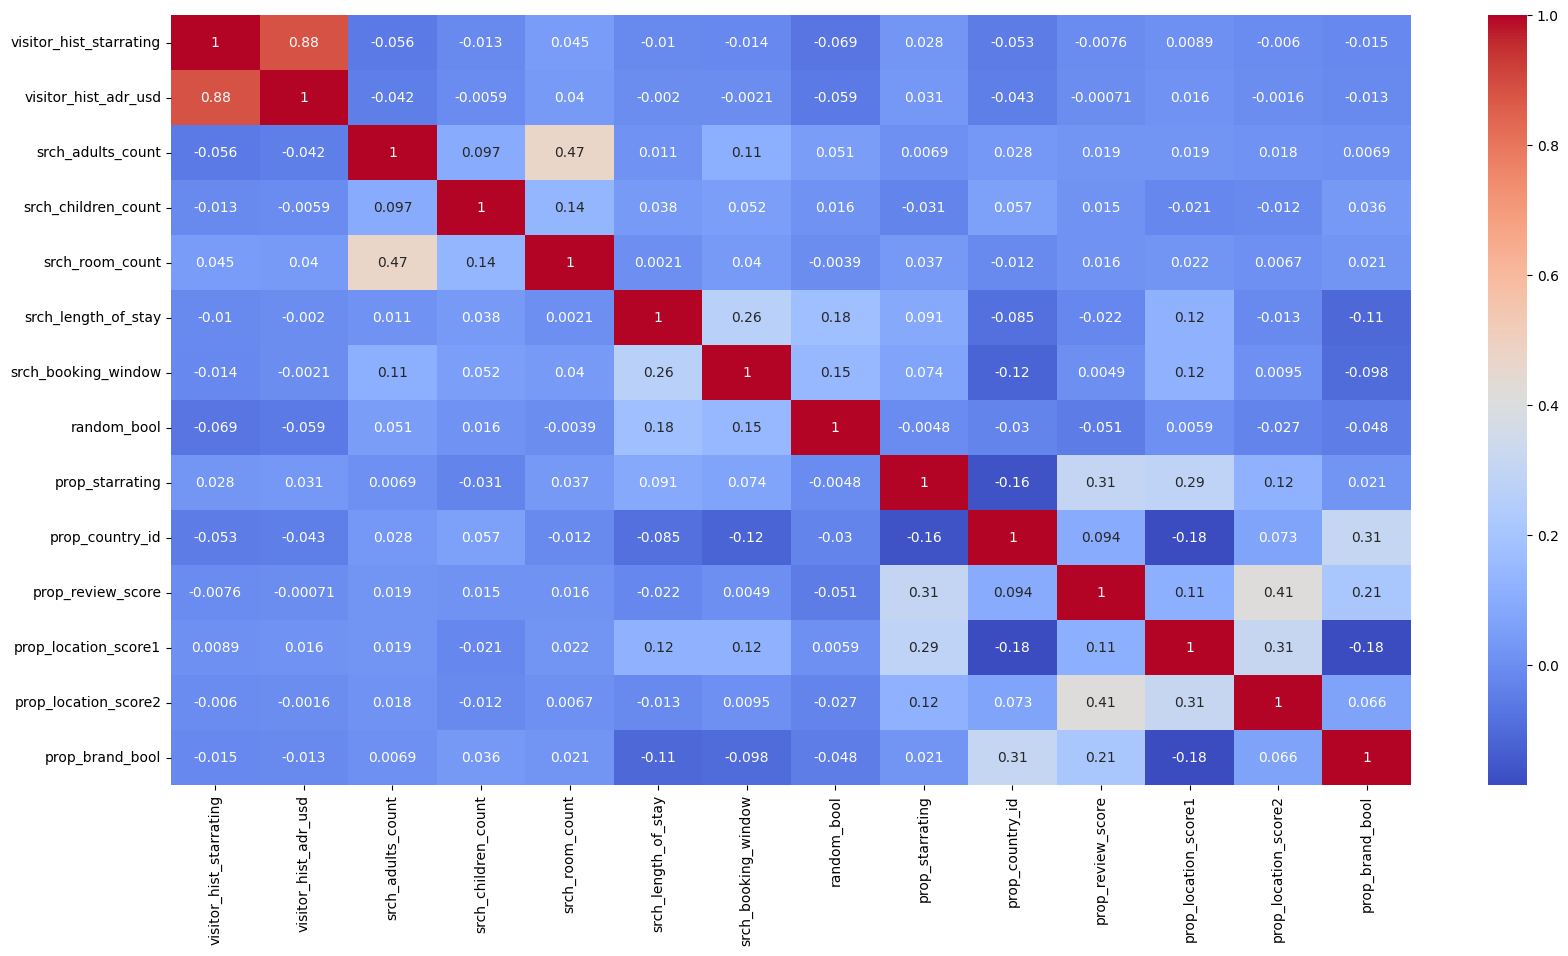

In [43]:
columns_to_include = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_length_of_stay', 'srch_booking_window', 'random_bool',
                      'prop_starrating', 'prop_country_id', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'prop_brand_bool']
user_data = td[columns_to_include]

# Normalize the data
normalized_data = (user_data - user_data.mean()) / user_data.std()

correlation_matrix = normalized_data.corr()

# plot correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [44]:
# drop Unnamed: 0 , date_time, prop_log_historical_price, srch_destination_id
td = td.drop(['Unnamed: 0', 'date_time', 'prop_log_historical_price', 'srch_destination_id'], axis=1)

In [45]:
# Define the weights for each criterion
booking_weight = 0.7
click_weight = 0.1
random_weight = 0.05
brand_weight = 0.05
prop_starrating_weight = 0.03
prop_review_score_weight = 0.03
prop_location_score1_weight = 0.01
prop_location_score2_weight = 0.01
position_weight = 0.02

# Calculate the score for each entry
td['score'] = (
    td['booking_bool'].apply(lambda x: booking_weight if x else 0) +
    td['click_bool'].apply(lambda x: click_weight if x else 0) +
    td['random_bool'].apply(lambda x: random_weight if x == 0 else 0) +
    td['prop_brand_bool'].apply(lambda x: brand_weight if x == 1 else 0) +
    td['prop_starrating'] * prop_starrating_weight +
    td['prop_review_score'] * prop_review_score_weight +
    td['prop_location_score1'].apply(lambda x: x if x != -1 else 0) * prop_location_score1_weight +
    td['prop_location_score2'].apply(lambda x: x if x != -1 else 0) * prop_location_score2_weight +
    (1 / td['position']) * position_weight
)

td['rank'] = td.groupby('srch_id')['score'].rank(method='min', ascending=True)

In [46]:
td = pd.merge(td, clicked_hotels, on="prop_id", how='left')

In [85]:
# Define the weights for each criterion
sum_book_weight = 0.4
click_interaction_weight = 0.2
search_perc_weight = 0.1
brand_weight = 0.1
prop_starrating_weight = 0.05
prop_review_score_weight = 0.05
prop_location_score1_weight = 0.025
prop_location_score2_weight = 0.025

# Calculate the score for each entry
td['test_score'] = (
    td["sum_booking"] * sum_book_weight +
    td['search_percentage'] * search_perc_weight +
    td['click_interaction'] * click_interaction_weight +
    td['random_bool'].apply(lambda x: random_weight if x == 0 else 0) +
    td['prop_brand_bool'].apply(lambda x: brand_weight if x == 1 else 0) +
    td['prop_starrating'] * prop_starrating_weight +
    td['prop_review_score'] * prop_review_score_weight +
    td['prop_location_score1'].apply(lambda x: x if x != -1 else 0) * prop_location_score1_weight +
    td['prop_location_score2'].apply(lambda x: x if x != -1 else 0) * prop_location_score2_weight
)

In [86]:
td_sample = td.sample(2000000, random_state=42) 

In [77]:
td.head(30)

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,srch_saturday_night_bool,random_bool,click_bool,booking_bool,score,rank,sum_booking,click_interaction,search_percentage,test_score
0,1,12,187,0.0,-1.0,219,893,3,3.5,1,...,1,1,0,0,0.274479,12.0,0.10,0.000007,0.047400,1.246845
1,1,12,187,0.0,-1.0,219,10404,4,4.0,1,...,1,1,0,0,0.312918,21.0,0.09,0.000007,0.045154,1.305373
2,1,12,187,0.0,-1.0,219,21315,3,4.5,1,...,1,1,0,0,0.298197,16.0,0.02,0.000007,0.042676,1.280612
3,1,12,187,0.0,-1.0,219,27348,2,4.0,1,...,1,1,0,0,0.259013,10.0,0.06,0.000005,0.035628,1.221062
4,1,12,187,0.0,-1.0,219,29604,4,3.5,1,...,1,1,0,0,0.307641,19.0,0.24,0.000008,0.051505,1.294103
5,1,12,187,0.0,-1.0,219,30184,4,4.5,1,...,1,1,0,0,0.336859,27.0,0.14,0.000008,0.049801,1.347505
6,1,12,187,0.0,-1.0,219,44147,3,3.5,1,...,1,1,0,0,0.268467,11.0,0.00,0.000003,0.016342,1.230890
7,1,12,187,0.0,-1.0,219,50984,2,0.0,0,...,1,1,0,0,0.076671,1.0,0.02,0.000001,0.008055,0.890250
8,1,12,187,0.0,-1.0,219,53341,4,4.0,1,...,1,1,0,0,0.323505,26.0,0.70,0.000009,0.061419,1.317095
9,1,12,187,0.0,-1.0,219,56880,4,4.0,1,...,1,1,0,0,0.321328,25.0,0.26,0.000008,0.052280,1.323320


In [68]:
td.columns

Index(['srch_id', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2', 'position', 'price_usd',
       'promotion_flag', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'random_bool', 'click_bool', 'booking_bool',
       'score', 'rank', 'sum_booking', 'click_interaction',
       'search_percentage', 'test_score'],
      dtype='object')

In [87]:
features = ['prop_starrating',
       'prop_review_score', 'prop_location_score1',
       'prop_location_score2',
       'price_usd','test_score',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'sum_booking', 'click_interaction',
       'search_percentage']

target = 'score'

# Split the data into train and test sets
train_data, test_data = train_test_split(td, test_size=0.2, random_state=0)

# Prepare the data for XGBoost
dtrain = xgb.DMatrix(train_data[features], label=train_data[target])
dtest = xgb.DMatrix(test_data[features], label=test_data[target])

# Set the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Train the XGBoost model
model = xgb.train(params, dtrain)

In [89]:
# Make predictions on the test set
preds = model.predict(dtest)

# Evaluate the model using root mean squared error (RMSE)
rmse = mean_squared_error(test_data[target], preds, squared=False)
print("RMSE: {:.4f}".format(rmse))

RMSE: 0.1302


without normalizing 0.1327 rmse
with normalizing 0.8674 rmse
without normalizing and features = ['prop_starrating', 'visitor_hist_starrating',
       'prop_review_score', 'prop_location_score1',
       'prop_location_score2',
       'price_usd','test_score',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'sum_booking', 'click_interaction',
       'search_percentage'] 0.1305 rmse


In [90]:
X = td_sample[features]
y = td_sample["score"]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the model
model = xgb.XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

RMSE: 0.12997838349241775


In [52]:
# # prepare test set
# test_df = pd.read_csv('files/test_set_VU_DM.csv')

# test_df = test_df.dropna(thresh=test_df.shape[0]*0.5,axis=1)
# test_df = test_df.drop(['orig_destination_distance'], axis=1)

In [53]:
# test_df = pd.merge(test_df, clicked_hotels, on="prop_id", how='left')

In [54]:
# null_score = test_df[test_df["prop_location_score2"].isnull()]["prop_id"]

# # get rows where prop_location_score2 is not null
# not_null_score = test_df[test_df["prop_location_score2"].notnull()][["prop_id", "prop_location_score2"]]

# # get mean of prop_location_score2 for each prop_id
# mean_score = not_null_score.groupby("prop_id").mean()
# mean_dict = mean_score.to_dict()["prop_location_score2"]

# # fill null values with mean
# test_df.loc[test_df["prop_location_score2"].isnull(), "prop_location_score2"] = test_df[test_df["prop_location_score2"].isnull()]["prop_id"].map(mean_dict)

In [55]:
# test_df["prop_location_score2"].fillna(-1, inplace=True)
# test_df["prop_review_score"].fillna(0, inplace=True)
# test_df["sum_booking"].fillna(0, inplace=True)
# test_df["click_interaction"].fillna(0, inplace=True)
# test_df["search_percentage"].fillna(0, inplace=True)

In [56]:
# Define the weights for each criterion
# sum_book = 0.5
# click_interaction_weight = 0.15
# search_perc_weight = 0.1
# brand_weight = 0.1
# prop_starrating_weight = 0.05
# prop_review_score_weight = 0.05
# prop_location_score1_weight = 0.025
# prop_location_score2_weight = 0.025

# # Calculate the score for each entry
# test_df['test_score'] = (
#     test_df["sum_booking"].apply(lambda x: sum_book) +
#     test_df['search_percentage'].apply(lambda x: search_perc_weight) +
#     test_df['click_interaction'].apply(lambda x: click_interaction_weight) +
#     test_df['random_bool'].apply(lambda x: random_weight if x == 0 else 0) +
#     test_df['prop_brand_bool'].apply(lambda x: brand_weight if x == 1 else 0) +
#     test_df['prop_starrating'] * prop_starrating_weight +
#     test_df['prop_review_score'] * prop_review_score_weight +
#     test_df['prop_location_score1'].apply(lambda x: x if x != -1 else 0) * prop_location_score1_weight +
#     test_df['prop_location_score2'].apply(lambda x: x if x != -1 else 0) * prop_location_score2_weight
# )

In [57]:
# X2 = xgb.DMatrix(test_df[features])

# preds = model.predict(X2)

# test_df["rank"] = preds

In [58]:
# deliverable = test_df[["srch_id", "prop_id", "rank"]]

# sort srch_id by ascending order and rank by descending order
# deliverable.sort_values(["srch_id", "rank"], ascending=[True, False], inplace=True)

In [59]:
# save to csv with only prop id and srch id 
# deliverable[["srch_id", "prop_id"]].to_csv("deliverable_ranking.csv", index=False)

In [60]:
# deliverable.shape